# Advice for the 2nd Project

The intent of this notebook is to give some tips for doing the second project.

First,

If you work with the level of charge offs, your rsquare will be very high and if you work with the difference in charge offs the rsquare will be very low.  This is an implication of "the best predictor of something is itself in the prior period."  I would like for you to do one of each.   For Credit Cards, the level is 'almost stationary' so let's assume it is and work in levels.  For Commerical Real Estate it is clearly not, so let's work in differences.

Second, when merging the data, I think it is easier to work by doing a left hand join on year and month where the left hand table is charge-offs.  This will always keep the charge off rates and not produce extraneous rows of data. When merging, keep in mind that this is a forecast model so we want to use information that would be available shortly after the end of quarter to forecast charges off that happen in the next quarter.  In the data we have given you the interpretation of date is 'charge offs for quarter ended', therefore we want to substract 100 days and then create month and year so it will merge correctly.

Please review carefully for the details.

In [1]:
import time as time
start_time = time.time()


# Stationary?
For cards, I recommend rounding down and treating the chargeoff rate on cards as stationary.
This will give you experience working with both a dependent variable that is in levels and a dependent variable that is changes.

By plotting the two series you see the difference.  Charges off for credit cards are relatively stable and mean reverting. Where as charge offs for CRE are typically close to zero except for during the financial crisis and therefore are non stationary.


In [2]:
#pip install pandas

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

path = '/Users/dwd4/Documents/Credit Risk Analytics/data/'
file_path1 = path + 'card.xlsx'
df1 = pd.read_excel(file_path1)
file_path2 = path + 'CRE.xlsx'
df2 = pd.read_excel(file_path2)
df1["chargeoff_rate_card"]=df1["chargeoffs"]/df1["loans"]
df2["chargeoff_rate_cre"]=df2["chargeoffs"]/df2["loans"]

print('Augmented Dickey Fuller for Credit Cards')
print(adfuller(df1["chargeoff_rate_card"])[1])
print('-----')

print('Augmented Dickey Fuller for Charge Offs')
print(adfuller(df2["chargeoff_rate_cre"])[1])



Augmented Dickey Fuller for Credit Cards
0.0532702340344809
-----
Augmented Dickey Fuller for Charge Offs
0.489129084901098


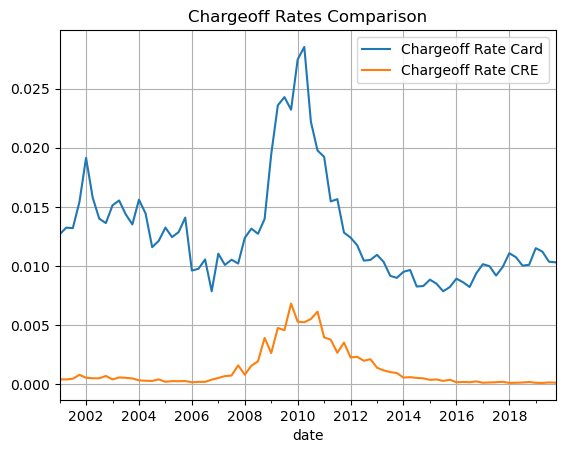

In [4]:
data = pd.merge(df1[['date','chargeoff_rate_card']],df2[['date','chargeoff_rate_cre']],on='date')

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data["chargeoff_rate_card"].plot()
data["chargeoff_rate_cre"].plot()

plt.legend(["Chargeoff Rate Card", "Chargeoff Rate CRE"])  # List the labels in the order of plotting
plt.title("Chargeoff Rates Comparison")  # Set the title for the plot
plt.grid()
plt.show()


# Timing Interpretation of Charge Offs
The first observation is for March 31, 2001.  This has the intrepretation that 1.2% of card card loans where charged in the accounting period ending March 31, 2001.

In [5]:
def head_n_tail(df):
    print('First Three Rows of Data')
    print(df.head(3))
    print('-----')
    print('Last Three Rows of Data')
    print(df.tail(3))
    print(type(df))
    print(df.shape)

    
head_n_tail(data)




First Three Rows of Data
            chargeoff_rate_card  chargeoff_rate_cre
date                                               
2001-03-31             0.012672            0.000422
2001-06-30             0.013246            0.000408
2001-09-30             0.013205            0.000470
-----
Last Three Rows of Data
            chargeoff_rate_card  chargeoff_rate_cre
date                                               
2019-06-30             0.011221            0.000114
2019-09-30             0.010365            0.000153
2019-12-31             0.010312            0.000136
<class 'pandas.core.frame.DataFrame'>
(76, 2)


In [6]:
unrate = web.DataReader("UNRATE", "fred", start = '2000-01-01')
print("Monthly Unemployment Data")

head_n_tail(unrate)


Monthly Unemployment Data
First Three Rows of Data
            UNRATE
DATE              
2000-01-01     4.0
2000-02-01     4.1
2000-03-01     4.0
-----
Last Three Rows of Data
            UNRATE
DATE              
2024-06-01     4.1
2024-07-01     4.3
2024-08-01     4.2
<class 'pandas.core.frame.DataFrame'>
(296, 1)


# Timing intrepretation of Unemployment and Merging

The most recent unemployment number is 4.0% for May 2024 and was released on June 7 2025 -- about a week after the end of month: see for example:

https://www.dol.gov/newsroom/releases/osec/osec20240607#:~:text=“Today%2C%20the%20Bureau%20of%20Labor,the%20longest%20stretch%20since%201970.

Therefore the information that would have been available at the begining of April 2024, would have been the March 2024 number (3.8).  One can think of the March 1, 2024 data as the value of the unemployment rate for the month of 2024 that became available shortly after the end of the month.


To merge, I recommend merging on the fields month and year which we construct according to how we want to structure the forecast data.  We want to predict Charges Off in the next quarter using data that would have been available at the beginning of the quarter.  Therefore, we want to subtract three months to the charge offs data.  To substract three months we can subtract 100 days, which is always a little more than 3 months so if will work when we convert to month and year.

The code below creates a new date and a month and a year from the existing data that push back the month and the year to the previous quarter by substracting 100 days, so when we merge on month and quarter the charge off rates will be reflective of what happened during the next quarter. 


In [7]:
from datetime import timedelta
data['new_date'] = data.index + timedelta(days = -100)
data['month'] = data.new_date.dt.month
data['year'] = data.new_date.dt.year
head_n_tail(data)

First Three Rows of Data
            chargeoff_rate_card  chargeoff_rate_cre   new_date  month  year
date                                                                       
2001-03-31             0.012672            0.000422 2000-12-21     12  2000
2001-06-30             0.013246            0.000408 2001-03-22      3  2001
2001-09-30             0.013205            0.000470 2001-06-22      6  2001
-----
Last Three Rows of Data
            chargeoff_rate_card  chargeoff_rate_cre   new_date  month  year
date                                                                       
2019-06-30             0.011221            0.000114 2019-03-22      3  2019
2019-09-30             0.010365            0.000153 2019-06-22      6  2019
2019-12-31             0.010312            0.000136 2019-09-22      9  2019
<class 'pandas.core.frame.DataFrame'>
(76, 5)


For unemployment we will construct the month and year from DATE rather than date, so that the unemployment number for month 3 and year 2024 reflects what was know about unemployment shortly after the end of the third quarter. 

In [8]:
unrate['new_date'] = unrate.index
unrate['month'] = unrate.new_date.dt.month
unrate['year'] = unrate.new_date.dt.year
head_n_tail(unrate)

First Three Rows of Data
            UNRATE   new_date  month  year
DATE                                      
2000-01-01     4.0 2000-01-01      1  2000
2000-02-01     4.1 2000-02-01      2  2000
2000-03-01     4.0 2000-03-01      3  2000
-----
Last Three Rows of Data
            UNRATE   new_date  month  year
DATE                                      
2024-06-01     4.1 2024-06-01      6  2024
2024-07-01     4.3 2024-07-01      7  2024
2024-08-01     4.2 2024-08-01      8  2024
<class 'pandas.core.frame.DataFrame'>
(296, 4)


In [9]:
data2 = pd.merge(data,unrate[['year','month','UNRATE']],on = ['year','month'], how = 'left')
head_n_tail(data2)

First Three Rows of Data
   chargeoff_rate_card  chargeoff_rate_cre   new_date  month  year  UNRATE
0             0.012672            0.000422 2000-12-21     12  2000     3.9
1             0.013246            0.000408 2001-03-22      3  2001     4.3
2             0.013205            0.000470 2001-06-22      6  2001     4.5
-----
Last Three Rows of Data
    chargeoff_rate_card  chargeoff_rate_cre   new_date  month  year  UNRATE
73             0.011221            0.000114 2019-03-22      3  2019     3.8
74             0.010365            0.000153 2019-06-22      6  2019     3.6
75             0.010312            0.000136 2019-09-22      9  2019     3.5
<class 'pandas.core.frame.DataFrame'>
(76, 6)


In [10]:
unrate.head(15)

,UNRATE,new_date,month,year
DATE,,,,
2000-01-01,4.0,2000-01-01,1,2000
2000-02-01,4.1,2000-02-01,2,2000
2000-03-01,4.0,2000-03-01,3,2000
2000-04-01,3.8,2000-04-01,4,2000
2000-05-01,4.0,2000-05-01,5,2000
2000-06-01,4.0,2000-06-01,6,2000
2000-07-01,4.0,2000-07-01,7,2000
2000-08-01,4.1,2000-08-01,8,2000
2000-09-01,3.9,2000-09-01,9,2000


In [11]:
import time as time
end_time = time.time()

print("Start time:", time.ctime(start_time))
print("End time:", time.ctime(end_time))

print([end_time-start_time])

Start time: Wed Oct  2 07:40:36 2024
End time: Wed Oct  2 07:40:38 2024
[1.3266711235046387]


Note that we have lined up the unemployment rate from year end 2000 (which would be available in the first week of 2001) with the charge off rates from the first quarter of 2001, so we are using information that would have been available at the beginning of the quarter to predict charge offs that occurred during the quarter. By using a 'left join' we eliminate the excess observations from the 'righthand table'.